In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\sk88\Documents\Python")

from Function_files.addresses import Init_Directories
import Function_files.data_functions as dat
from Function_files.plotting_functions import plot_scope
from Function_files.filter_functions import smooth_data 
from Function_files.math_functions import average_arrays, zoom
from Function_files.fitting_functions import fit_gls, peak_find, pseudo_voigt, lorentzian, fit_lorentz

import os
import numpy as np
import matplotlib.pyplot as mp

dirs = Init_Directories()
path = dirs.dropbox + "Paderborn EIT"
exts = '.csv'

di = dict(

time = 0,
scan = 1,
probe = 2

)

In [2]:
# populate folder and file lists
folder_list, file_list = dat.dir_interogate(path, extensions=exts)
# create dictionary for indexing folders and files
folder_index = dat.make_index_dict(folder_list)
file_index = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# lists of the data paths and metadata (text) paths
data_path_list = dat.search_paths(folder_list, file_list, exts)
metadata_path_list = dat.search_paths(folder_list, file_list, exts)
# extract the relevant data from the files
EIT_10MHz_sets = [dat.open_csv(os.path.join(path, data_path)) for data_path in data_path_list[folder_index['10MHz Scan']]]
EIT_window_sets = [dat.open_csv(os.path.join(path, data_path)) for data_path in data_path_list[folder_index['EIT window']]]
Other_sets = [dat.open_csv(os.path.join(path, data_path)) for data_path in data_path_list[folder_index['Other']]]

In [9]:
# convert timebase to frequency and find N points between scans
N = []
for excel in EIT_10MHz_sets:
    a, b = zoom(excel[:,di['time']], (-0.5, 0.5))
    N.append(b-a)

# convert to frequency
dv = [10E6/(n) for n in N]
frequency = [excel[:,di['time']] * v for excel, v in zip(EIT_10MHz_sets, dv)]
# smooth data and fidn peaks
smoothed = [smooth_data(excel[:,di['scan']]) for excel in EIT_10MHz_sets]
peaks = [peak_find(smooth, freq, top_tol=0.5, dist=n) for smooth, freq, n in zip(smoothed, frequency, N)]

[ 0.42        0.00092656 -0.16286954]
[ 1.05000e+00  9.26880e-04 -1.91611e-02]
[ 1.05000e+00 -2.31720e-04 -1.91611e-02]
[ 1.05       -0.00393924 -0.0191611 ]
[ 1.05        0.00277968 -0.0480688 ]
[ 1.05        0.00139032 -0.0480688 ]
[ 1.05       -0.00185376 -0.0480688 ]
[ 1.050000e+00 -2.317200e-04 -5.287568e-02]
[ 1.05       0.        -0.0480688]
[ 1.050000e+00 -4.634400e-04 -5.287568e-02]


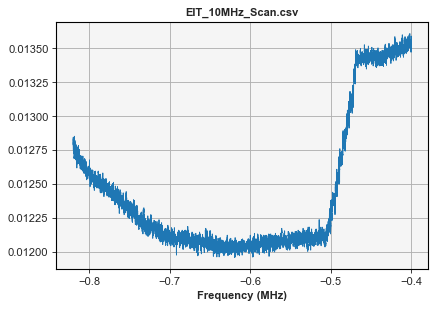

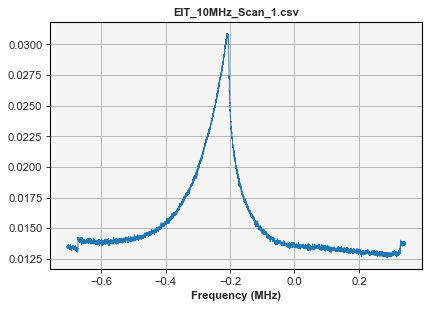

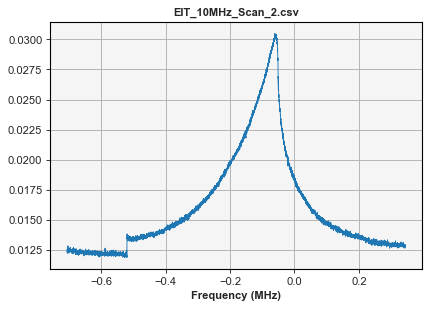

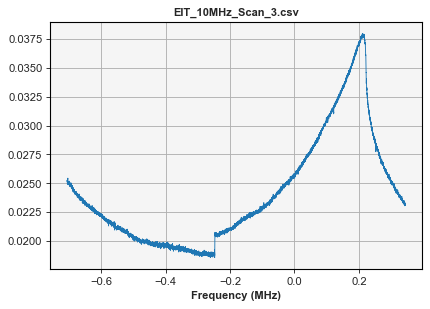

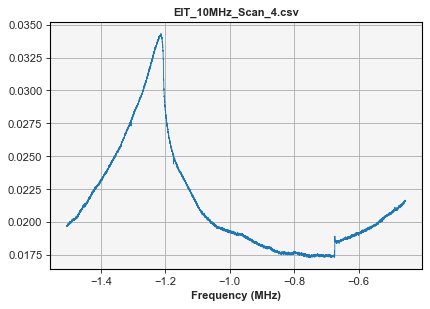

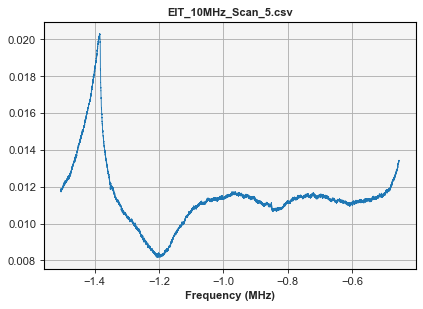

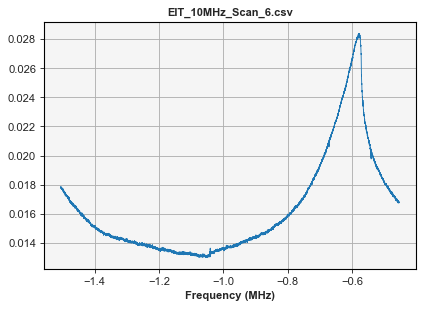

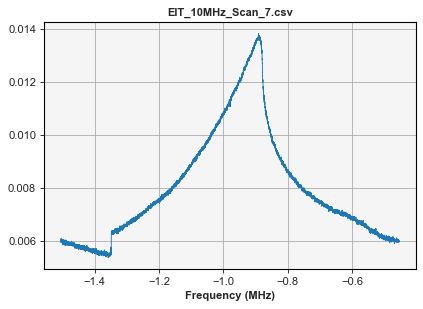

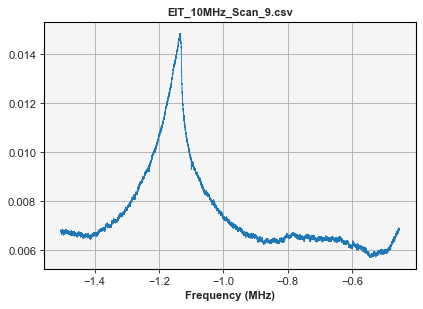

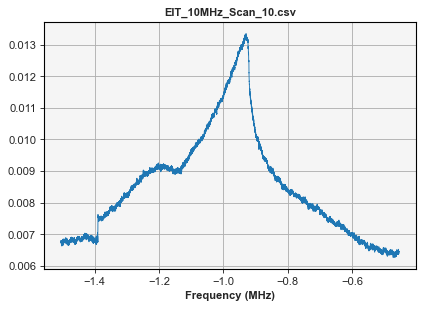

In [27]:
# plot the smoothed data with peaks
index = 0
for freq, smooth, peak in zip(EIT_10MHz_sets, smoothed, peaks):

    print(freq[300000] - freq[90000])

    fig, ax = mp.subplots()
    ax.plot(freq[90000:300000,di['time']], smooth[90000:300000])
    ax.set_title(list(file_index[folder_index['10MHz Scan']])[index])
    ax.set(xlabel='Frequency (MHz)')
    index += 1

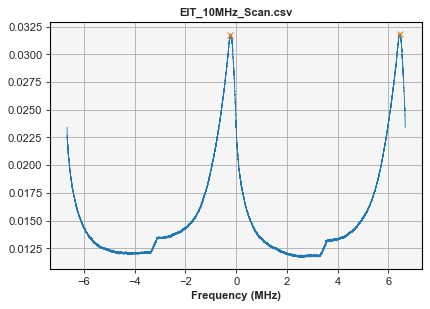

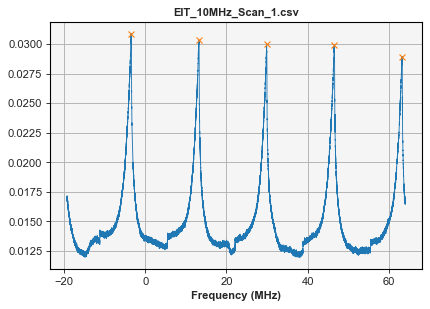

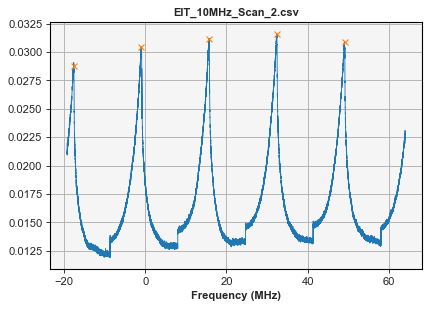

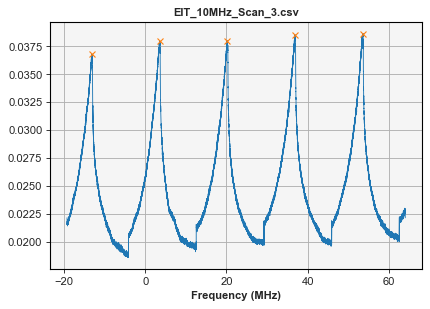

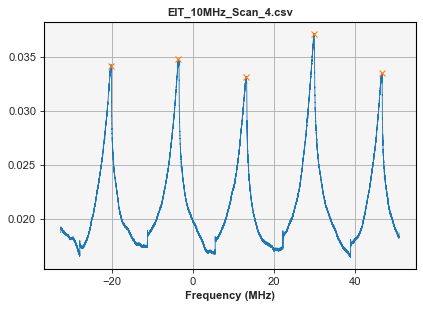

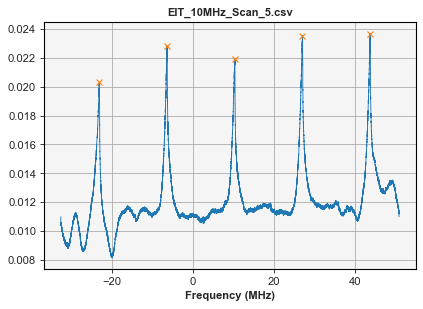

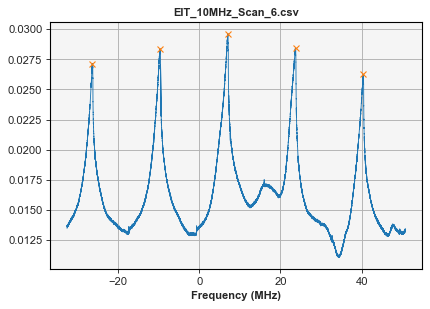

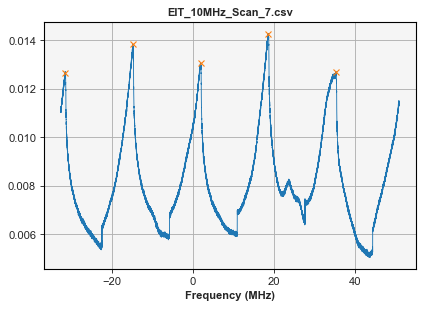

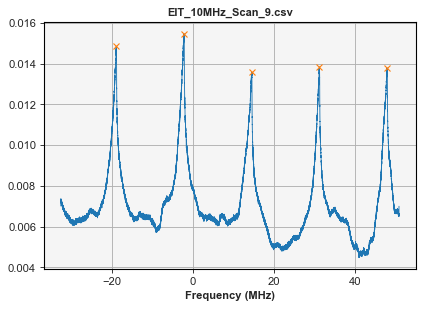

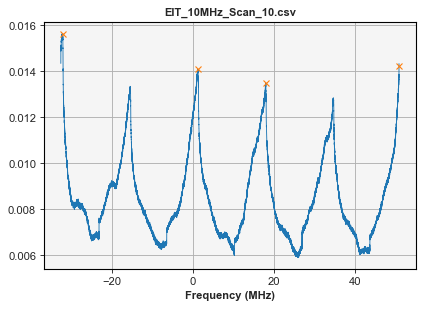

In [10]:
# plot the smoothed data with peaks
index = 0
for freq, smooth, peak in zip(frequency, smoothed, peaks):

    fig, ax = mp.subplots()
    ax.plot(freq, smooth)
    ax.plot(freq[peak], smooth[peak], 'x')
    ax.set_title(list(file_index[folder_index['10MHz Scan']])[index])
    ax.set(xlabel='Frequency (MHz)')
    index += 1

In [ ]:
# isolate the individual peaks and pad around these points for fitting to a single peak
window_idx = []
for peak_set, n in zip(peaks, N):
    temp = []
    for peak in peak_set:
        start = int(peak - n/2)
        stop = int(peak + n/2)
        if start < 0:
            start = 0
        if stop > 1000000:
            stop = -1
        temp.append(np.array([start, stop]))
    window_idx.append(temp)

In [ ]:
# plot the individual peaks in each dataset
index = 0
for freq, smooth, peak, indexes in zip(frequency, smoothed, peaks, window_idx):
    for place, idx in enumerate(indexes):
        fig, ax = mp.subplots()
        ax.plot(freq[idx[0]:idx[1]], smooth[idx[0]:idx[1]])
        ax.plot(freq[peak[place]], smooth[peak[place]], 'x')
        ax.set_title(list(file_index[folder_index['10MHz Scan']])[index])
        ax.set(xlabel='Frequency (MHz)')
    index += 1

In [7]:
# fit to the peaks in each plot
index = 0
l_fitted = []
vp_fitted = []
for freq, smooth, peak, indexes in zip(frequency, smoothed, peaks, window_idx):
    l_temp = []
    vp_temp = []
    for place, idx in enumerate(indexes):
        
        top = smooth[peak[place]]
        low = min(smooth[idx[0]:idx[1]])
        mid = freq[peak[place]]
        width = (freq[idx[1]]-freq[idx[0]])/2

        try:
            l_fit = fit_lorentz(freq[idx[0]:idx[1]], smooth[idx[0]:idx[1]], (top, low, mid, width))
            vp_fit = fit_gls(freq[idx[0]:idx[1]], smooth[idx[0]:idx[1]], (low, top, mid, width, top, mid, width, 0.2))
            l_temp.append(l_fit)
            vp_temp.append(vp_fit)
        except:
            l_temp.append([])
            vp_temp.append([])
    l_fitted.append(l_temp)
    vp_fitted.append(vp_temp)

In [ ]:
# plot the fitted peaks in each dataset
index = 0
for freq, smooth, peak, indexes, vp_fit in zip(frequency, smoothed, peaks, window_idx, vp_fitted):
    for idx, vp_params in zip(indexes, vp_fit):

        fig, ax = mp.subplots()
        ax.plot(freq[idx[0]:idx[1]], smooth[idx[0]:idx[1]])
        try:
            ax.plot(freq[idx[0]:idx[1]], pseudo_voigt(freq[idx[0]:idx[1]], *vp_params[0]), label='vp')
            ax.set_title(list(file_index[folder_index['10MHz Scan']])[index])
            ax.set(xlabel='Frequency (MHz)')
            ax.legend()
        except:
            print('fit fail')
        
        
    index += 1

In [ ]:
# plot the fitted peaks in each dataset
index = 0
for freq, smooth, peak, indexes, l_fit in zip(frequency, smoothed, peaks, window_idx, l_fitted):
    for idx, l_params in zip(indexes, l_fit):

        fig, ax = mp.subplots()
        try:
            ax.plot(freq[idx[0]:idx[1]], lorentzian(freq[idx[0]:idx[1]], *l_params[0]), label='lorentz')
            ax.plot(freq[idx[0]:idx[1]], smooth[idx[0]:idx[1]])
            ax.set_title(list(file_index[folder_index['10MHz Scan']])[index])
            ax.set(xlabel='Frequency (MHz)')
            ax.legend()
        except:
            print('fit_fail')
    index += 1

In [ ]:
delta_nu = []
for x in l_fitted:
    temp = []
    for y in x:
        if y:
            temp.append(y[0][-1])
    delta_nu.append(temp)

In [ ]:
linewidths_1 = [1.424, 2.722, 4.188, 6]
pump_1 = [1.1, 2, 4, 3]
linewidths_2 = []
pump_2 = [1, 2.6, 3.8, 1.5]

In [ ]:
delta_nu[3]

In [ ]:
fig, ax = mp.subplots()
for index, nu in enumerate(linewidths_1):
    ax.plot(pump_1[index], nu, 'x')
    ax.legend(['Probe 20uW'])
for index, nu in enumerate(linewidths_2):
    ax.plot(pump_2[index], nu, 'o')
    ax.legend(['Probe 10uW'])